pip install torch torchvision torchaudio

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
else:
    print ("MPS device not found.")


mps


torch.Size([250, 250, 3])


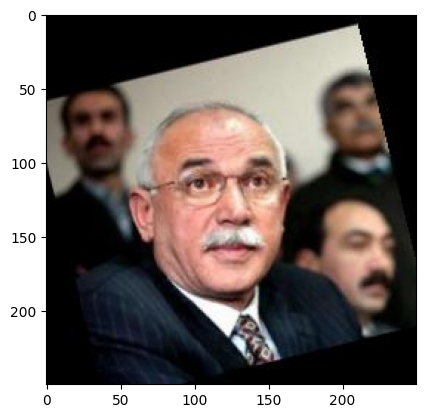

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

*Channels:* The first dimension in the image shape (image_shape[0]) represents the number of color channels. In standard RGB images, this is usually 3 (corresponding to Red, Green, and Blue channels).

*Height:* The second dimension (image_shape[1]) is the height of the image in pixels. It tells you how many pixels there are from the top to the bottom of the image.

*Width:* The third dimension (image_shape[2]) is the width of the image in pixels. This is the number of pixels from the left to the right side of the image.

In summary, the shape [C, H, W] means there are C color channels, each with a dimension of H pixels in height and W pixels in width. When displaying the image with matplotlib, the image needs to be permuted to [H, W, C] since matplotlib expects the color channels to be the last dimension.

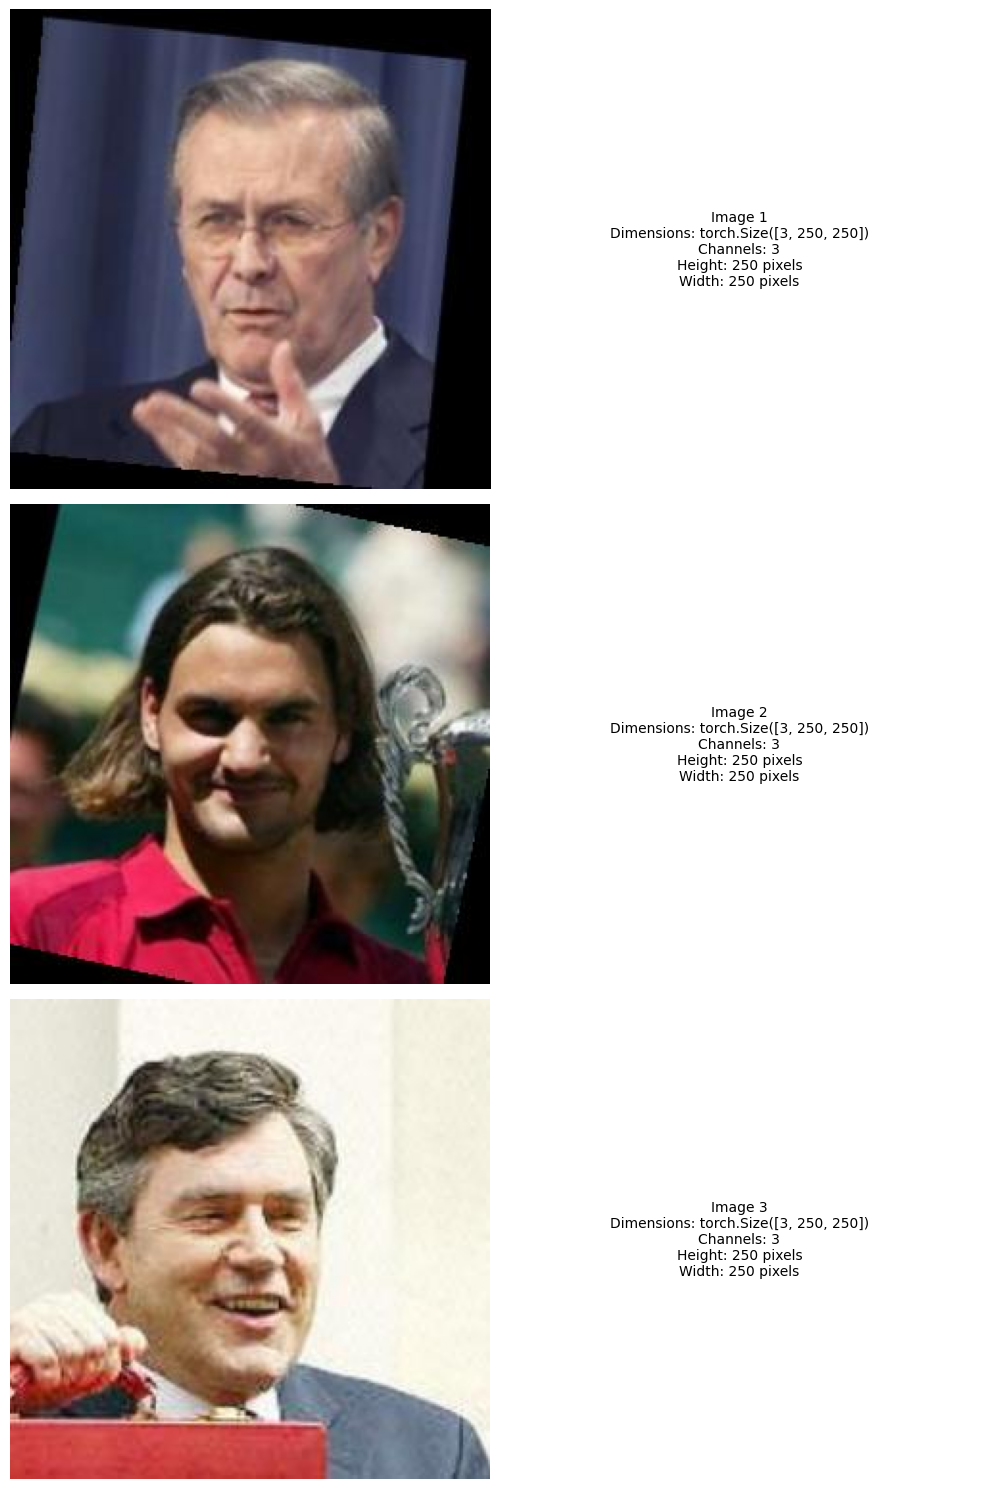

In [7]:
# import matplotlib.pyplot as plt

# Assuming 'dataloader' is already defined
num_images_to_show = 3
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 15))  # Adjust the size as needed

for i, (x, y) in enumerate(dataloader):
    if i >= num_images_to_show:
        break

    image = x[0]  # Get the first image in the batch
    image_shape = image.shape  # Shape of the image

    # Permute the image for display ([C, H, W] to [H, W, C])
    image_display = image.permute(1, 2, 0)

    # Display the image
    axes[i, 0].imshow(image_display)
    axes[i, 0].axis('off')  # Hide the axis

    # Display the text
    text_str = f"Image {i+1}\nDimensions: {image_shape}\nChannels: {image_shape[0]}\nHeight: {image_shape[1]} pixels\nWidth: {image_shape[2]} pixels"
    axes[i, 1].text(0.5, 0.5, text_str, ha='center', va='center')
    axes[i, 1].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()
# for x, y in dataloader:
#     print("Batch Shape:", x.shape)  # This prints the shape of the batch
#     break

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: [32, x/2, y/2]
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, x/4, y/4]
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: [128, x/8, y/8]
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, x/4, y/4]
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: [32, x/2, y/2]
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0),  # Output: [3, x, y]
            nn.Sigmoid()
        )

    def encoder(self, x):
        return self.encoder_layers(x)

    def decoder(self, x):
        return self.decoder_layers(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [9]:
model = AE()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if MPS (Apple's Metal Performance Shaders) is available and use it
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Move your model to the MPS device and set it to evaluation mode
model = model.to(device)
model.eval()

# Get a sample image from the dataloader
for images, _ in dataloader:
    sample_image = images[0].unsqueeze(0)  # Add a batch dimension
    break

# Move your input data to the MPS device
sample_image = sample_image.to(device)

# Pass the image through the model
with torch.no_grad():  # No need to track gradients for this
    encoded_output = model.encoder(sample_image)
    print("Encoded Output Shape:", encoded_output.shape)

    reconstructed_image = model.decoder(encoded_output)
    print("Decoded Output Shape:", reconstructed_image.shape)

Using device: mps
Encoded Output Shape: torch.Size([1, 128, 31, 31])
Decoded Output Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 331715


In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

For an autoencoder, especially when dealing with images, a common choice for a loss function is the Mean Squared Error (MSE) loss. This loss function is effective for tasks where you need to measure how close the reconstructed images are to the original images, on a pixel-by-pixel basis.

MSE loss works well when the output image is expected to closely match the input image. If your task has different requirements (like if it's more important to preserve certain features over others), you might consider other loss functions or even a custom loss function.

In [13]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming you have already defined your model
model = AE()  # Ensure AE is your model class name

# Set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the chosen device
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

num_epochs = 40

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in dataloader:
        inputs, _ = batch  # Assuming dataloader returns (input, label)
        inputs = inputs.to(device)  # Move inputs to the same device as the model
        optimizer.zero_grad()

        # Forward pass
        encoded = model(inputs)
        
        # Calculate the loss
        loss = loss_function(encoded, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Using device: mps
Epoch 1, Loss: 0.005233054517505124
Epoch 2, Loss: 0.0016260924490375651
Epoch 3, Loss: 0.0013522931428317988
Epoch 4, Loss: 0.0011334878649531103
Epoch 5, Loss: 0.001029360079817285
Epoch 6, Loss: 0.0009088277721728068
Epoch 7, Loss: 0.0008242895121878499
Epoch 8, Loss: 0.0007615839557892054
Epoch 9, Loss: 0.0006799484106935875
Epoch 10, Loss: 0.000620128229276754
Epoch 11, Loss: 0.0006185852414799026
Epoch 12, Loss: 0.0006273778124233249
Epoch 13, Loss: 0.0005557394733006845
Epoch 14, Loss: 0.0005299092002172509
Epoch 15, Loss: 0.00048658591855411834
Epoch 16, Loss: 0.0004738382533263496
Epoch 17, Loss: 0.0004429558693720388
Epoch 18, Loss: 0.0004140027877587852
Epoch 19, Loss: 0.0004155040206978152
Epoch 20, Loss: 0.00040962677465156757
Epoch 21, Loss: 0.000389577649156383
Epoch 22, Loss: 0.00036453472878215926
Epoch 23, Loss: 0.00038618220019594044
Epoch 24, Loss: 0.00035961611879846655
Epoch 25, Loss: 0.00033631584394620823
Epoch 26, Loss: 0.00031395821309376256


##  Step 7
Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
import random
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Choose a random index from the dataset
random_index = random.randint(0, len(dataloader) - 1)

# Retrieve the random image
sample_image, _ = dataloader.dataset[random_index]

# Move the image to the same device as the model
sample_image = sample_image.to(device)

# Pass the image through the model to get the encoded and decoded outputs
with torch.no_grad():
    encoded_output = model.encoder(sample_image.unsqueeze(0))
    decoded_output = model.decoder(encoded_output)

# Convert the tensors to numpy arrays for plotting
sample_image_np = sample_image.cpu().numpy().transpose(1, 2, 0)
decoded_image_np = decoded_output[0].cpu().numpy().transpose(1, 2, 0)

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(decoded_image_np)
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Choose a random index from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)

# Retrieve the random image
sample_image, _ = dataloader.dataset[random_index]

# Move the image to the same device as the model
sample_image = sample_image.to(device)

# Pass the image through the model to get the encoded output
with torch.no_grad():
    encoded_output = model.encoder(sample_image.unsqueeze(0))

# Increase the standard deviation for more noise
noise_stddev = 0.5  # Increased noise level
noise = torch.randn_like(encoded_output) * noise_stddev
noisy_encoded_output = encoded_output + noise

# Decode the noisy encoded representation
with torch.no_grad():
    decoded_output = model.decoder(noisy_encoded_output)

# Convert the tensors to numpy arrays for plotting
sample_image_np = sample_image.cpu().numpy().transpose(1, 2, 0)
decoded_image_np = decoded_output[0].cpu().numpy().transpose(1, 2, 0)

# Plot the original and reconstructed (noisy) images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(decoded_image_np)
axes[1].set_title("Reconstructed (Noisy) Image")
axes[1].axis('off')

plt.show()
